In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import feature_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [2]:
RANDOM_STATE = 42
DATA_EXTERNAL = "../data/external/"
DATA_PROCESSED = "../data/processed/"
DATA_INTERIM = "../data/interim/"

In [3]:
hum = pd.read_csv(DATA_PROCESSED + "humsavar_gt.tab.gz", sep="\t")
# hum["MUTANT"] = hum.MUTANT.str.rstrip()
hum.drop_duplicates(inplace=True)
hum.drop_duplicates(subset="MUTANT", keep=False, inplace=True)
protparam = pd.read_csv(DATA_INTERIM + "protparam_features.tab.gz", sep="\t")
hum = hum.merge(protparam, on="MUTANT", how="left")
phastCons46way = pd.read_csv("../data/interim/phastCons46way.csv")
phastCons46way.rename(columns={"name": "dbSNP"}, inplace=True)
phyloP46way = pd.read_csv("../data/interim/phyloP46way.csv")
phyloP46way.rename(columns={"name": "dbSNP"}, inplace=True)

hum = hum.merge(phastCons46way, on="dbSNP", how="left")
hum = hum.merge(phyloP46way, on="dbSNP", how="left")
hum.drop("dbSNP", axis=1, inplace=True)
hum.rename(columns={"phastCons46way": "PHASTCONS46WAY"}, inplace=True)
hum.rename(columns={"phyloP46way": "PHYLOP46WAY"}, inplace=True)

In [4]:
hum.to_csv(DATA_PROCESSED + "humsavar_gt.csv.gz", sep=",", index=False, compression="gzip")

In [5]:
hum = pd.read_csv(DATA_PROCESSED + "humsavar_gt.csv.gz", sep=",")

In [6]:
hum.head()

,MUTANT,3DID,ACTIVE_SITE,AGGREGABILITY,BFACTOR,CONSERVATION,PDB,SASA,SASA_PERCENTAGE,SWITCHBILITY,...,VAR_GRAVY,GRAVY,GRAVY_DIFF,GRAVY_LOG_RATIO,VAR_INSTABILITY_INDEX,INSTABILITY_INDEX,INSTABILITY_INDEX_DIFF,INSTABILITY_INDEX_LOG_RATIO,PHASTCONS46WAY,PHYLOP46WAY
0,P11362-174-V-A,False,NaN,0.0,32.280,NaN,False,6.038,0.03,NaN,...,-0.033333,0.07500,0.108333,0.106222,63.513333,58.36875,5.144583,-0.083104,NaN,NaN
1,Q8WZA1-504-V-I,False,NaN,NaN,67.465,NaN,False,90.814,0.51,0.0000,...,-0.120000,0.15000,0.270000,0.267595,18.600000,7.45000,11.150000,-0.841363,0.997,2.987
2,P46100-243-C-F,False,BINDING,NaN,0.000,NaN,False,1.143,0.00,0.0661,...,-0.360000,-0.60000,0.240000,-0.470004,59.026667,55.96250,3.064167,-0.052396,NaN,NaN
3,P11473-362-T-I,False,NaN,NaN,11.290,NaN,False,0.214,0.00,0.0000,...,-0.146667,-0.68125,0.534583,-0.984743,81.013333,31.76875,49.244583,-0.917407,0.814,1.194
4,Q9NXN4-106-G-S,True,NaN,0.0,37.430,0.24,False,0.000,0.00,0.0410,...,-1.346667,-1.48125,0.134583,0.328023,43.633333,15.85000,27.783333,-0.974130,1.000,5.583


In [7]:
hum.describe()

,AGGREGABILITY,BFACTOR,CONSERVATION,SASA,SASA_PERCENTAGE,SWITCHBILITY,VARIATION_ENERGY,VAR_AROMATICITY,AROMATICITY,AROMATICITY_DIFF,...,VAR_GRAVY,GRAVY,GRAVY_DIFF,GRAVY_LOG_RATIO,VAR_INSTABILITY_INDEX,INSTABILITY_INDEX,INSTABILITY_INDEX_DIFF,INSTABILITY_INDEX_LOG_RATIO,PHASTCONS46WAY,PHYLOP46WAY
count,5136.000000,7000.000000,2600.000000,7000.000000,7000.00000,6559.000000,7427.000000,7427.000000,7427.000000,7427.000000,...,7426.000000,7426.000000,7426.000000,6873.000000,7426.000000,7426.000000,7426.000000,6885.000000,5172.000000,5172.000000
mean,5.009965,57.097037,0.331554,32.785369,0.15468,0.381191,2.820931,0.096264,0.095211,0.019058,...,-0.209155,-0.210446,0.233199,NaN,37.134868,41.019175,13.458861,0.070223,0.855227,3.283833
std,17.702566,70.447180,0.191846,39.433521,0.17928,0.881307,4.797885,0.078765,0.080456,0.025838,...,0.768189,0.779319,0.174817,NaN,31.851082,32.925821,12.899362,0.714906,0.322805,2.192184
min,0.000000,0.000000,0.130000,0.000000,0.00000,0.000000,-8.746030,0.000000,0.000000,0.000000,...,-2.740000,-2.875000,0.000000,-inf,-47.066667,-38.193750,0.001250,-7.221495,0.000000,-7.452000
25%,0.000000,20.426875,0.250000,0.676000,0.00000,0.000000,0.237110,0.066667,0.062500,0.004167,...,-0.720000,-0.731250,0.090521,-0.221459,14.143333,16.573438,3.852500,-0.181444,0.987000,1.377000
50%,0.000000,38.357500,0.300000,16.036500,0.08000,0.008020,1.449850,0.066667,0.062500,0.008333,...,-0.240000,-0.243750,0.199583,0.000442,33.353333,37.065625,9.692917,0.017865,1.000000,3.746000
75%,0.146250,62.500000,0.370000,54.582750,0.27000,0.274000,3.686540,0.133333,0.125000,0.016667,...,0.273333,0.275000,0.340000,0.237328,56.746667,61.150000,19.145833,0.334560,1.000000,5.140000
max,100.000000,755.610000,4.770000,246.410000,0.75000,8.720000,57.513400,0.466667,0.500000,0.222222,...,3.386667,3.275000,1.272222,inf,183.067333,195.775000,105.460417,4.830811,1.000000,6.424000


In [8]:
hum.replace([np.inf,-np.inf], np.nan, inplace=True)

In [176]:
model_dict = {
    'lr':{'pipe':('lr', LogisticRegression(random_state=RANDOM_STATE)),
          'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
          'name':'LogisticRegression'
    },
    'rf':{'pipe':('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
          'params':[{'rf__max_depth':[3,5,7, 10], 'rf__n_estimators':[5, 7, 10], 'rf__max_features':[4,'sqrt',0.2, 10, 15]}],
          'name':'Random Forest'
    },
    'svc':{'pipe':('svc', SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True)),
           'params':[{'svc__C':[0.001, 0.01, 0.1, 1, 10], 'svc__gamma':[0.001, 0.01, 0.1, 1]}],
           'name': 'Support Vector Classifier'
    }
}

In [10]:
dataset = hum.drop(['3DID', 'PDB'], 1) \
    .replace({"ACTIVE_SITE": {"BINDING": 1, np.nan: 0}}) \
    .set_index("MUTANT")

unclassified_index = dataset[dataset.TYPE == "Unclassified"].index
dataset_disease_index = dataset[dataset.TYPE == "Disease"].index
dataset_poly_index = dataset[dataset.TYPE == "Polymorphism"].index

#### 50-50% en el set de entrenamiento y 60-40% en set de evaluación respetando humsavar

In [22]:
dataset.shape

(7427, 27)

In [23]:
dataset.TYPE.value_counts()

Disease         4664
Polymorphism    2161
Unclassified     602
Name: TYPE, dtype: int64

In [158]:
for i in range(20):
    train = pd.concat([
        dataset.loc[dataset_disease_index].sample(n=1300, random_state=i),
        dataset.loc[dataset_poly_index].sample(n=1300, random_state=i)
    ]).sample(frac=1)

    test = pd.concat([
        dataset.loc[dataset_disease_index.difference(train.index)].sample(n=1291, random_state=i),
        dataset.loc[dataset_poly_index.difference(train.index)].sample(n=861, random_state=i)
    ]).sample(frac=1)
    train.to_csv(DATA_PROCESSED + "train_test_sets/train_{}.tab.csv".format(i), sep="\t", index=True, index_label="MUTANT")
    test.to_csv(DATA_PROCESSED + "train_test_sets/test_{}.tab.csv".format(i), sep="\t", index=True, index_label="MUTANT")

#### Random Forest

In [177]:
algorithm = 'rf'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), 
                  model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=3, n_jobs=2, scoring='roc_auc', verbose=1, refit=True)

In [178]:
rf_train_scores = []
rf_test_scores = []
for i in range(20):
    train = pd.read_csv(DATA_PROCESSED + "train_test_sets/train_{}.tab.csv".format(i), sep="\t", index_col="MUTANT")
    test = pd.read_csv(DATA_PROCESSED + "train_test_sets/test_{}.tab.csv".format(i), sep="\t", index_col="MUTANT")
    X_train = train.drop("TYPE", 1)
    y_train = train.TYPE
    X_test = test.drop("TYPE", 1)
    y_test = test.TYPE
    le = LabelEncoder().fit(y_train)
    gs.fit(X_train, le.transform(y_train))
    print("Parameters: ", gs.best_params_)
#     print("Score train ({}): {}".format(i, gs.best_score_))
    rf = gs.best_estimator_
    y_pred = rf.predict(X_test)
    test_score = roc_auc_score(le.transform(y_test), y_pred)
#     print("Score test ({}): {}".format(i, score))
    rf_test_scores.append(test_score)
    rf_train_scores.append(gs.best_score_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    4.0s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 10, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.7s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.5s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.5s finished


Parameters:  {'rf__max_depth': 7, 'rf__max_features': 10, 'rf__n_estimators': 7}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.4s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    4.2s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 10, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.5s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.7s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.8s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 10, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.5s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 10, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Parameters:  {'rf__max_depth': 7, 'rf__max_features': 10, 'rf__n_estimators': 7}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.9s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 10, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    4.2s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 10, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.6s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.4s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.5s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    4.3s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Parameters:  {'rf__max_depth': 7, 'rf__max_features': 10, 'rf__n_estimators': 10}
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.8s finished


Parameters:  {'rf__max_depth': 5, 'rf__max_features': 15, 'rf__n_estimators': 10}


[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:    3.7s finished


In [179]:
print("MEAN: ", np.mean(rf_train_scores))
print("STDDEV: ", np.std(rf_train_scores))

MEAN:  0.947033968369
STDDEV:  0.00373221597079


In [180]:
print("MEAN: ", np.mean(rf_test_scores))
print("STDDEV: ", np.std(rf_test_scores))

MEAN:  0.654076848476
STDDEV:  0.00971862763065


In [37]:
print("MEAN: ", np.mean(rf_test_scores))
print("STDDEV: ", np.std(rf_test_scores))

('MEAN: ', 0.72969057324016551)
('STDDEV: ', 0.015551354855780321)


In [32]:
print("MEAN: ", np.mean(test_scores))
print("STDDEV: ", np.std(test_scores))

MEAN:  0.686163625776
STDDEV:  0.0153715857644


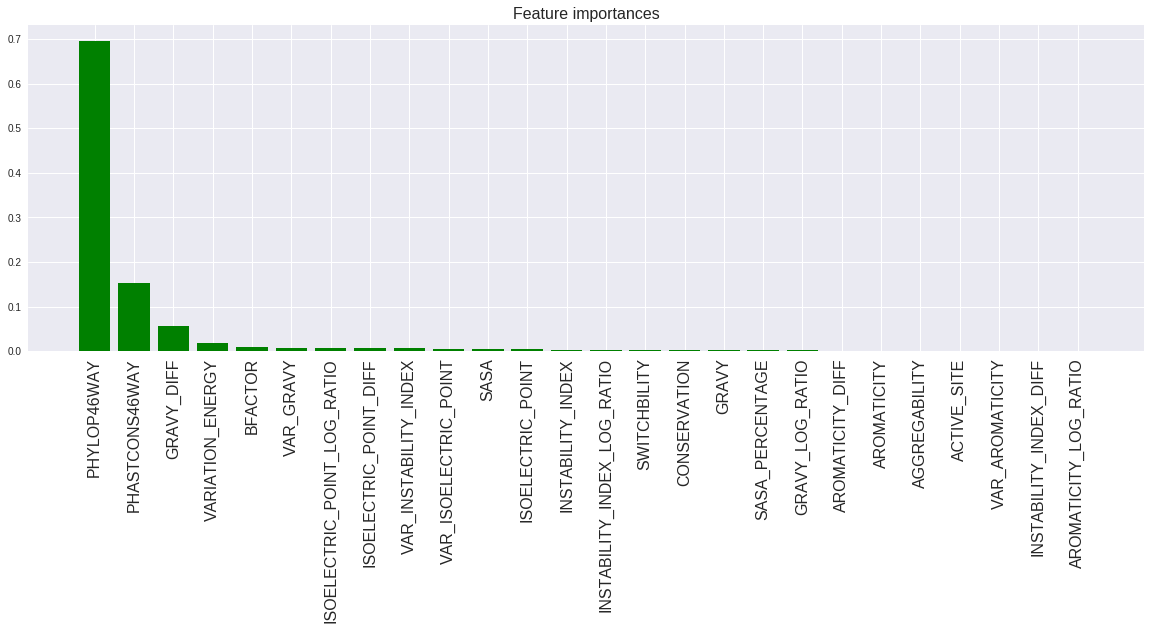

In [181]:
importances = [(X_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
figsize(20,6)
plt.title("Feature importances", fontsize=16)
plt.bar(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xticks(range(len(importances)), [x for x, y in importances], rotation='vertical', fontsize=16)
# plt.xlim([0, range(len(importances))])
plt.show()

#### Y los unclassified?

In [39]:
pd.Series(le.inverse_transform(rf.predict(dataset.loc[unclassified_index].drop("TYPE", 1)))).value_counts()

Disease         434
Polymorphism    170
dtype: int64

#### Support Vector Classifier

In [18]:
algorithm = 'svc'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), 
                  ('scale', StandardScaler()), 
                  model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=3, n_jobs=2, scoring='roc_auc', verbose=1, refit=True)

In [19]:
svc_train_scores = []
svc_test_scores = []
for i in range(20):
    train = pd.read_csv(DATA_PROCESSED + "train_test_sets/train_{}.tab.csv".format(i), sep="\t", index_col="MUTANT")
    test = pd.read_csv(DATA_PROCESSED + "train_test_sets/test_{}.tab.csv".format(i), sep="\t", index_col="MUTANT")
    X_train = train.drop("TYPE", 1)
    y_train = train.TYPE
    X_test = test.drop("TYPE", 1)
    y_test = test.TYPE
    le = LabelEncoder().fit(y_train)
    gs.fit(X_train, le.transform(y_train))
#     print("Score train ({}): {}".format(i, gs.best_score_))
    svc = gs.best_estimator_
    y_pred = svc.predict(X_test)
    score = roc_auc_score(le.transform(y_test), y_pred)
#     print("Score test ({}): {}".format(i, score))
    svc_train_scores.append(gs.best_score_)
    svc_test_scores.append(score)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   36.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   44.9s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   35.4s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   43.6s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   38.4s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   47.1s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   37.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   46.4s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   38.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   46.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   39.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   48.5s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   38.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   47.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   42.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   51.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   39.4s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   50.0s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.0min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   37.1s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   47.3s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   50.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   59.0s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   37.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   47.7s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   36.1s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   44.4s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   39.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   47.7s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   43.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   54.0s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   46.1s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   56.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   38.1s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   47.2s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   41.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   49.3s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   35.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   43.3s finished


In [20]:
print("MEAN: ", np.mean(svc_train_scores))
print("STDDEV: ", np.std(svc_train_scores))

MEAN:  0.926119033333
STDDEV:  0.00312282080089


In [42]:
print("MEAN: ", np.mean(svc_train_scores))
print("STDDEV: ", np.std(svc_train_scores))

('MEAN: ', 0.78233960000000002)
('STDDEV: ', 0.0054555224473310905)


In [46]:
print("MEAN: ", np.mean(svc_train_scores))
print("STDDEV: ", np.std(svc_train_scores))

MEAN:  0.715766533333
STDDEV:  0.0063637597678


In [21]:
print("MEAN: ", np.mean(svc_test_scores))
print("STDDEV: ", np.std(svc_test_scores))

MEAN:  0.620360701346
STDDEV:  0.019505474099


In [62]:
y_proba = pd.DataFrame(svc.predict_proba(X_test))[0]

In [64]:
svc_results = pd.DataFrame({"y_pred": y_pred, "y_true": le.transform(y_test), "score": y_proba})

In [65]:
svc_results.to_csv("../results/svc_results.csv", index=False)